# Import library

In [194]:
import rasterio
import torchgeo
import torch
import torch.nn as nn
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

# Define function

In [195]:
# create image patches
# inherit from torch.nn.Module class
class Patchify(nn.Module):
    def __init__(self, patch_size=512):
        super().__init__()  # call the __init__ function of the parent class
        self.p = patch_size
        # unfold function is for extracting patches
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size) # stride = patch_size to avoid overlapping patches

    def forward(self, x):
        # x is input tensor
        # x -> Batch size, channels, height, width
        bs, c, h, w = x.shape
        
        x = self.unfold(x)
        # x -> Batch size, (channels*patch size*patch size), L (number of patches)
        
        # Reshaping into the shape we want -> view() helps flatten the input
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

# Import data

In [196]:
sentinel2_path = '../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff'
data = rioxarray.open_rasterio(sentinel2_path)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

Min and max normalization give the worst result according to https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af

In [197]:
# Normalize the bands to the range [0, 1]
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [198]:
# 2th percentile to 98th percentile
# Apply a percentile-based contrast stretch (ignore the extreme values so image isn't too dark or too bright)
def contrast_stretch(array, lower_percentile=2, upper_percentile=98):
    lower = np.percentile(array, lower_percentile)
    upper = np.percentile(array, upper_percentile)
    array = np.clip(array, lower, upper) # clip -> limit the values in an array to specific range
    return (array - lower) / (upper - lower) # normalization

In [199]:
# 1th percentile to 99th percentile
# Apply a percentile-based contrast stretch (ignore the extreme values so image isn't too dark or too bright)
def contrast_stretch_new(array, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(array, lower_percentile)
    upper = np.percentile(array, upper_percentile)
    print('lower: ', lower)
    print('upper: ', upper)
    array = np.clip(array, lower, upper) # clip -> limit the values in an array to specific range
    return (array - lower) / (upper - lower) # normalization

lower:  4.0
upper:  4145.0


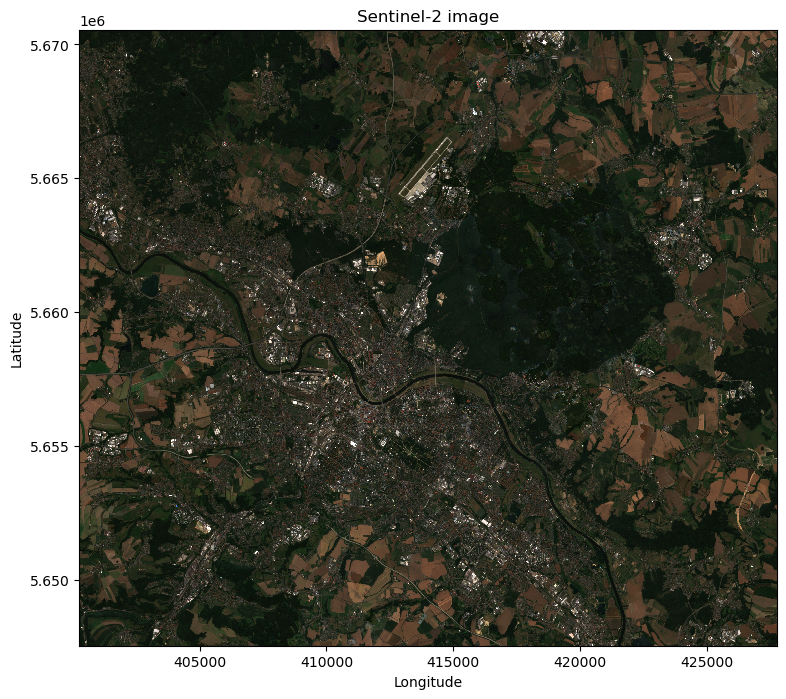

In [200]:
# Plot the raster data
plt.figure(figsize=(9,8))
# normalize(data).sel(band=[4, 3, 2]).plot.imshow()
contrast_stretch_new(data).sel(band=[4, 3, 2]).plot.imshow()
plt.title("Sentinel-2 image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [201]:
patch = Patchify()

# Convert DataArray to NumPy array
# img = contrast_stretch(data).sel(band=[4, 3, 2]).values  # Convert xarray DataArray to NumPy

img = contrast_stretch(data).values
print("img length:", len(img))

# Check if it's a multi-band image
# if len(img.shape) == 3:  
#     img = np.stack([img[0], img[1], img[2]], axis=-1)  # RGB bands

# image = img.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.from_numpy(img)
print("image shape:", image.shape)

# image = image.permute(2, 0, 1) # change the order of the dimensions (height, width, channels) to (channels, height, width)
image = image.unsqueeze(0) # to add the batch dimension in the 0th position

p = patch(image)
p = p.squeeze() # to remove the batch dimension for plotting

img length: 13
image shape: torch.Size([13, 2301, 2747])


In [202]:
print(p.shape)

torch.Size([20, 13, 512, 512])


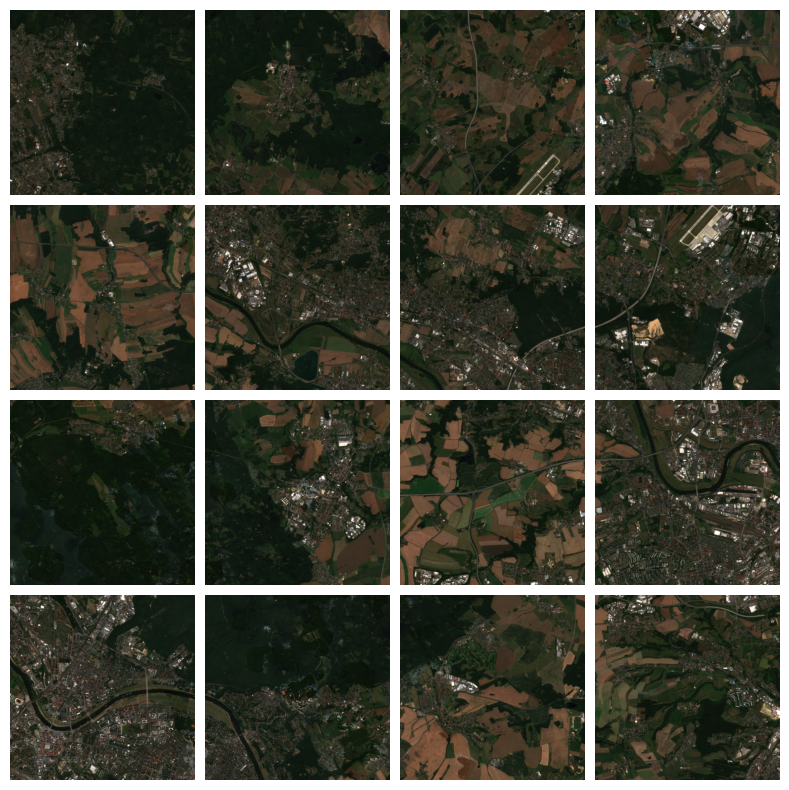

In [203]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_patches(tensor):
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

    for i, ax in enumerate(grid):
        temp_tensor = tensor[i].permute(1, 2, 0)
        patch = np.stack([temp_tensor[:,:,3], temp_tensor[:,:,2], temp_tensor[:,:,1]], axis=-1)  # RGB bands
        # format of imshow function is (height, width, channels)
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

plot_patches(p)

# Test by using torchgeo

In [204]:
from torchgeo.datasets import RasterDataset, VectorDataset, unbind_samples, stack_samples, Sentinel2
from pyproj import CRS

train_ds = RasterDataset(paths=sentinel2_path, crs=CRS.from_epsg(32633), res=10)

In [205]:
train_ds.bounds

BoundingBox(minx=400260.0, maxx=427730.0, miny=5647540.0, maxy=5670550.0, mint=0.0, maxt=9.223372036854776e+18)

In [206]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size=(512, 512), length=100)

In [207]:
import torch # this is to get the same result in every pass

torch.manual_seed(0)
bbox = next(iter(sampler))
print(bbox)
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

BoundingBox(minx=402230.0, maxx=407350.0, miny=5649900.0, maxy=5655020.0, mint=0.0, maxt=9.223372036854776e+18)
dict_keys(['crs', 'bounds', 'image'])
torch.Size([13, 512, 512])


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

lower:  4.0
upper:  4206.0
(13, 512, 512)


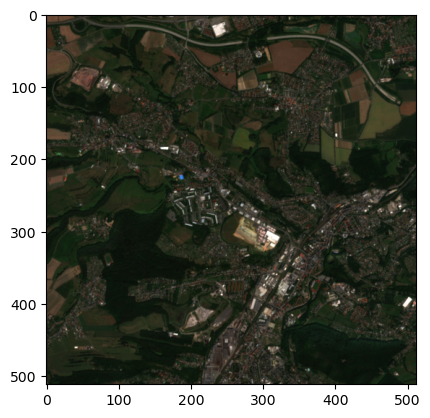

In [208]:
import torch
import matplotlib.pyplot as plt

# arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
arr = contrast_stretch_new(sample['image']).numpy()
# arr = torch.from_numpy(arr)
print(arr.shape)
# Transpose the array to get the correct shape for RGB (height, width, channels)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2 , 1]]

plt.imshow(rgb)

In [209]:
train_label = VectorDataset(paths='../data/processed/osm/public_green_spaces_dresden.geojson', crs=CRS.from_epsg(32633), res=10)

/root/miniforge3/envs/pugs-detection-new/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [210]:
new_train_ds = train_ds & train_label

In [216]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(new_train_ds, size=(128, 128), length=100)

In [217]:
torch.manual_seed(0)
bbox = next(iter(sampler))
sample = new_train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)
print(sample['mask'].shape)

dict_keys(['crs', 'bounds', 'image', 'mask'])
torch.Size([13, 128, 128])
torch.Size([128, 128])


/root/miniforge3/envs/pugs-detection-new/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


lower:  4.0
upper:  4138.0899999999965
(13, 128, 128)


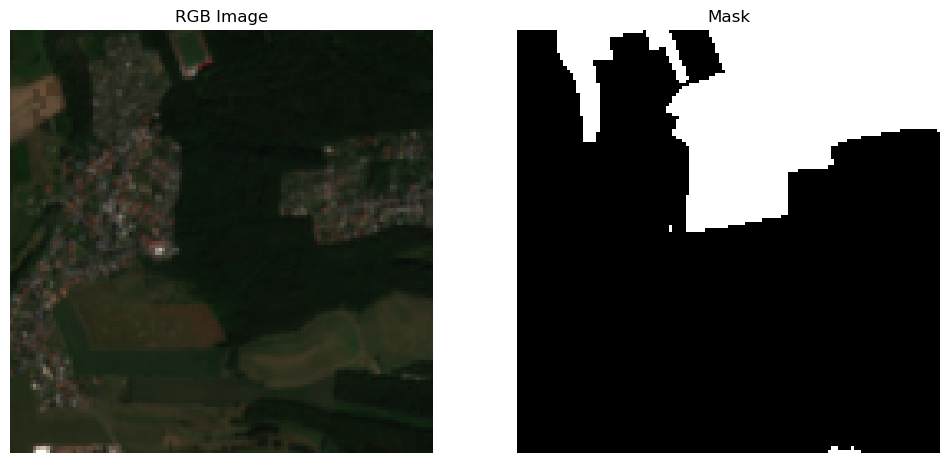

In [218]:
arr = contrast_stretch_new(sample['image']).numpy()
mask = sample['mask'].numpy()

# Print the shape of the image array
print(arr.shape)

# Transpose the array to get the correct shape for RGB (height, width, channels)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2, 1]]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the RGB image in the first subplot
axes[0].imshow(rgb)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Display the mask in the second subplot
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

# Show the figure
plt.show()

lower:  4.0
upper:  4138.0899999999965
(13, 128, 128)


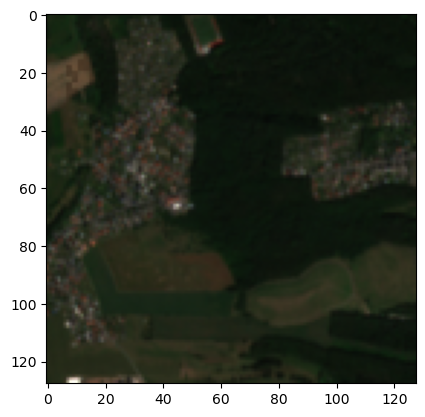

In [219]:
import torch
import matplotlib.pyplot as plt

# arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
arr = contrast_stretch_new(sample['image']).numpy()
# arr = torch.from_numpy(arr)
print(arr.shape)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2 , 1]]

plt.imshow(rgb)